## Setup, Loading Data and CDFs

In [14]:
DATA_NAME = 'approx1e5-agriVision-wavelet-blue' # Dataset Format: size-name-transform-channel

In [15]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
path_dict = dict(zip(['size', 'name', 'transform', 'channel'], DATA_NAME.split("-")))
CWD = os.path.join(ROOT_DIR, os.path.join("results", "case-studies", path_dict['name'], path_dict['transform'], path_dict['size'], path_dict['channel']))
assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "groupCDFs")).mkdir(exist_ok=True)

GROUP = 'layer' if path_dict['transform'] == 'wavelet' else ('band' if path_dict['transform'] == 'fourier' else 'error')
RERUN = True
CWD

'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/agriVision/wavelet/approx1e5/blue'

In [16]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [18]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{DATA_NAME}-size.pickle'))

if path_dict['transform'] == 'fourier':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif path_dict['transform'] == 'wavelet':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = [os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)]
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[1:]:
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::1000] for g in GROUPS} # For quick testing purposes
group_total_samples

{2: 9000,
 3: 36000,
 4: 144000,
 5: 576000,
 6: 2304000,
 7: 9216000,
 8: 36864000,
 9: 147456000,
 10: 589824000}

/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:582: RuntimeWarning: invalid value encountered in scalar divide
  var_prior = scale * scipy.special.gamma(beta + 1/r)/scipy.special.gamma(beta)
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:590: RuntimeWarning: overflow encountered in scalar multiply
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:590: RuntimeWarning: overflow encountered in scalar power
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:590: RuntimeWarning: invalid value encountered in scalar divide
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamm

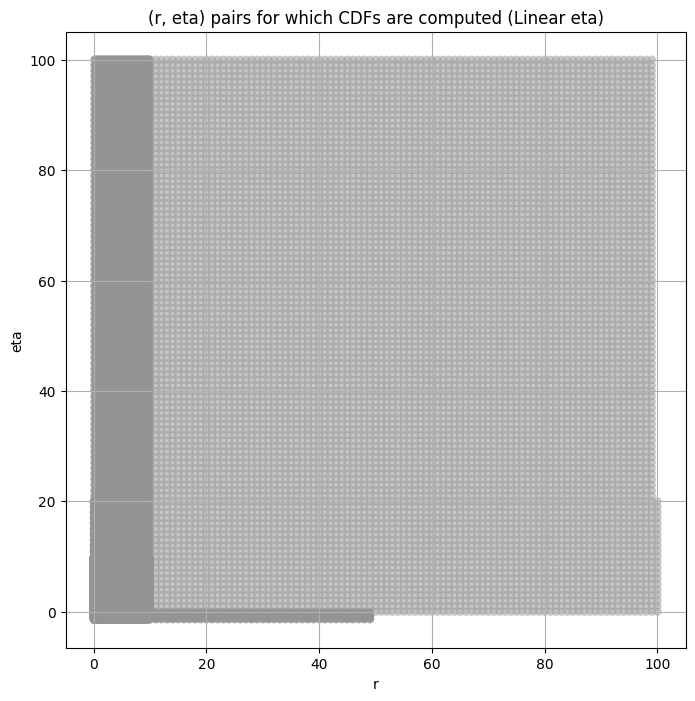

(r,eta),cdf     r  eta  \
0  ((0.02, -1.4), <scipy.interpolate._fitpack2.In...  0.02 -1.4   
1  ((0.02, -1.3), <scipy.interpolate._fitpack2.In...  0.02 -1.3   
2  ((0.02, -1.2), <scipy.interpolate._fitpack2.In...  0.02 -1.2   
3  ((0.02, -1.1), <scipy.interpolate._fitpack2.In...  0.02 -1.1   
4  ((0.02, -1.0), <scipy.interpolate._fitpack2.In...  0.02 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  9.618487e+69   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.821735e+74   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.455488e+78   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.406735e+81   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  5.331443e+83   

       kurtosis  
0  1.391529e+25  
1  8.172634e+21  
2  4.131785e+19  
3  6.947275e+17  
4  2.562075e+16

In [ ]:
#warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
coarse_cdf_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 0) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 0) == all_cdfs_df['eta'])]
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [ ]:
n_bootstrap = int(1e5)
bootstrap_size = int(1e4)
ci = 0.99

In [ ]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists():
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

obs_var     var_lower      var_upper    obs_kurt  kurt_lower  \
layer                                                                       
2      188570.730000  99638.340000  330262.220000   536.03296  113.304540   
3       42568.312000  23773.760000   71607.330000   488.99530  135.974520   
4       10773.336000   5322.670000   20877.791000   785.24280  131.392270   
5        1800.434900    923.853000    3624.655000   858.03740  109.913740   
6         390.887500    183.288650     971.469850  1521.53970  104.035530   
7          98.479220     41.024357     351.604030  3306.70500   84.348870   
8          33.173733     15.926921     100.374084  2264.61400   78.321760   
9          11.252635      4.427865      43.877705  5137.09860   82.329865   
10          1.875914      0.615992      10.184826  9775.98100   78.684250   

       kurt_upper  total_samples  
layer                             
2       760.94360         9000.0  
3       891.27313        36000.0  
4      1768.95340       144000.0  
5      2074.88330       576000.0  
6      3444.52950      2304000.0  
7      5672.12000      9216000.0  
8      4638.63770     36864000.0  
9      6105.37160    147456000.0  
10     7496.85840    589824000.0

## Initial Grid Search and Hypothesis Test Plots

####
Layer  2
0
Variance: 0.0 - 1.7976931348623157e+308
Scale: 3.496531681688498e-304 - 100000.0


100%|██████████| 55966/55966 [00:20<00:00, 2781.30it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 9000, Without approximation : 9000.0


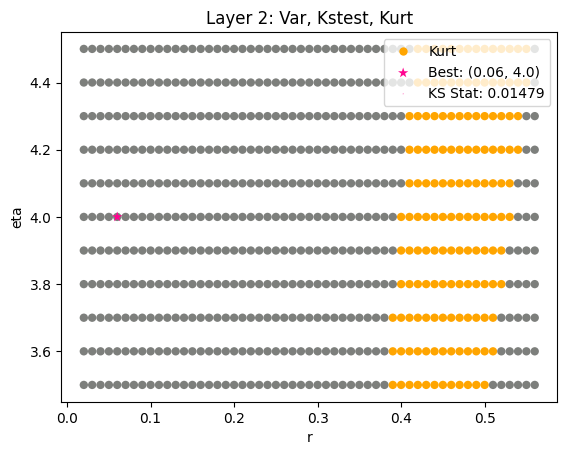

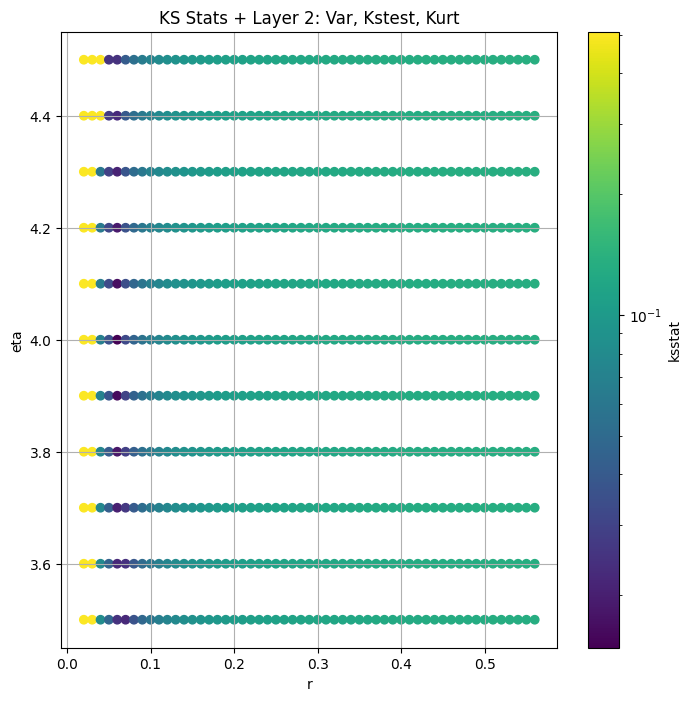

####
Layer  3
0
Variance: 0.0 - 1.7976931348623157e+308
Scale: 7.893136519331535e-305 - 100000.0


100%|██████████| 55966/55966 [01:07<00:00, 823.27it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 36000, Without approximation : 36000.0


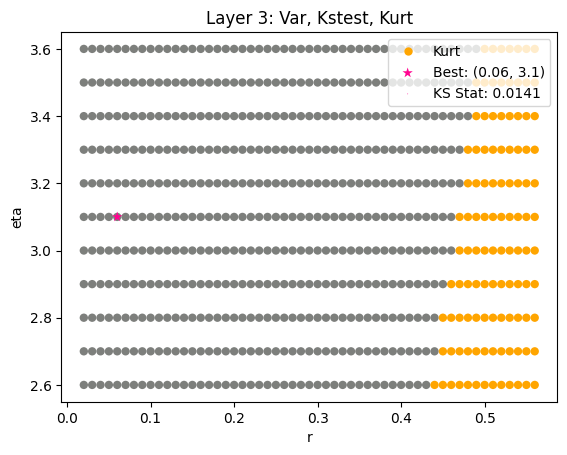

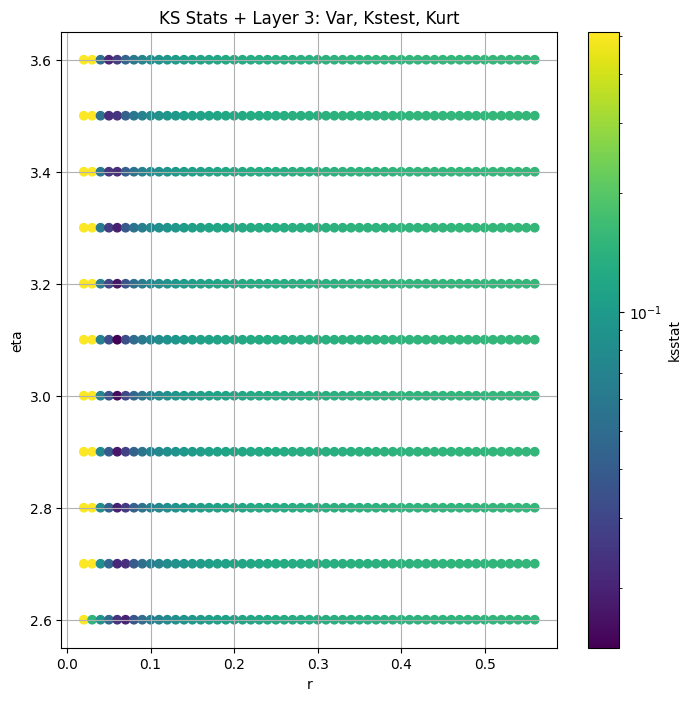

####
Layer  4
0
Variance: 0.0 - 1.7976931348623157e+308
Scale: 1.9976223585428783e-305 - 100000.0


100%|██████████| 55966/55966 [03:08<00:00, 296.65it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 144000.0


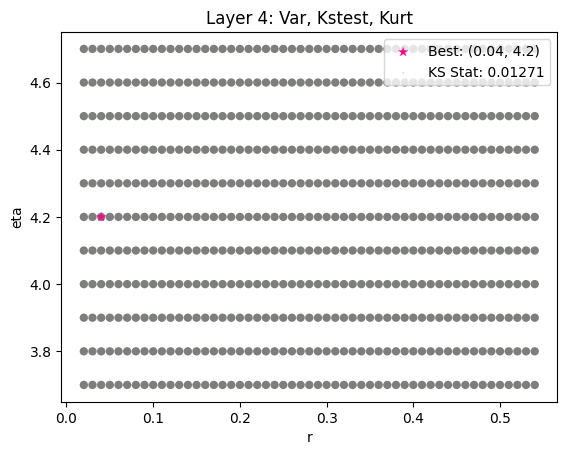

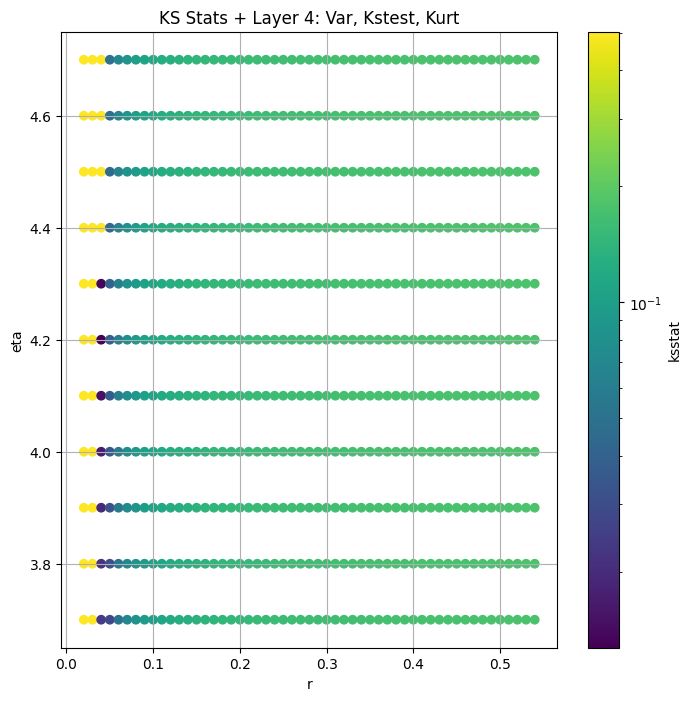

####
Layer  5
0
Variance: 0.0 - 1.7976931348623157e+308
Scale: 3.33841719161169e-306 - 100000.0


100%|██████████| 55966/55966 [03:06<00:00, 299.95it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 576000.0


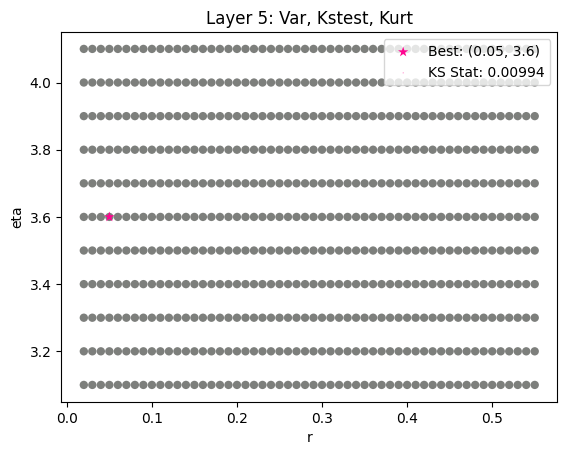

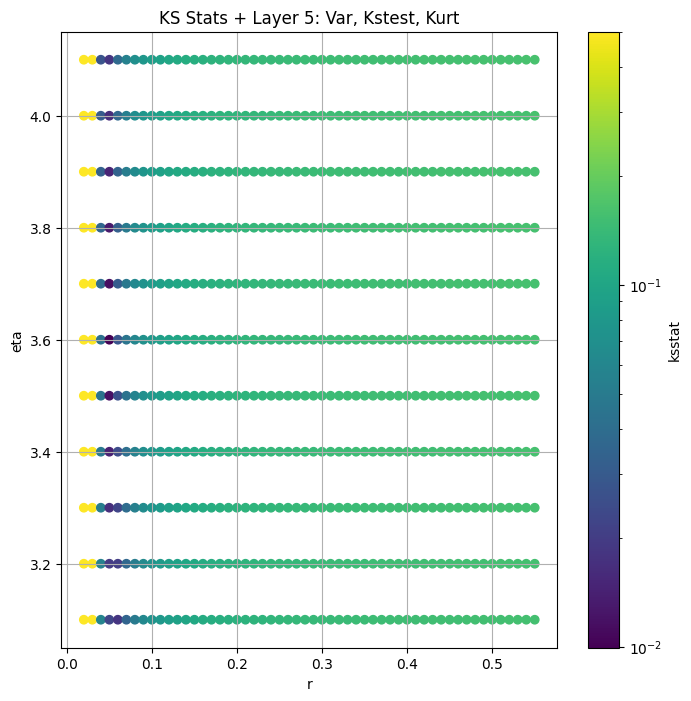

####
Layer  6
0
Variance: 0.0 - 1.7976931348623157e+308
Scale: 7.247946315560282e-307 - 100000.0


100%|██████████| 55966/55966 [03:02<00:00, 307.25it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 2304000.0


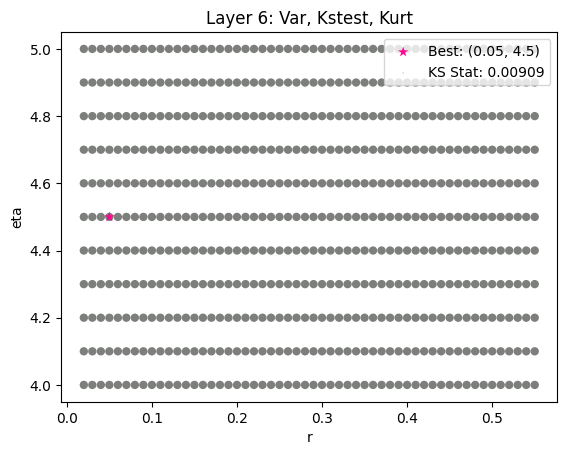

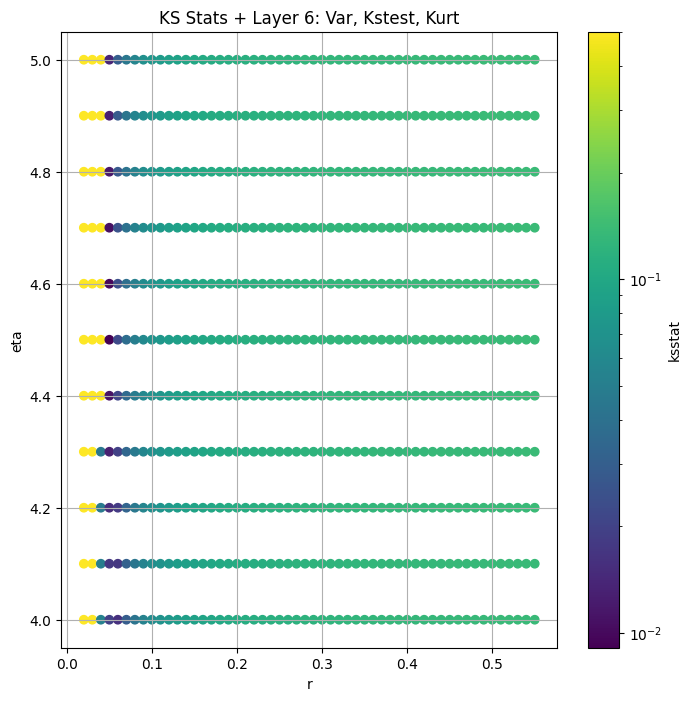

####
Layer  7
0
Variance: 0.0 - 1.7976931348623157e+308
Scale: 1.8260294835681632e-307 - 100000.0


100%|██████████| 55966/55966 [03:02<00:00, 306.82it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 9216000.0


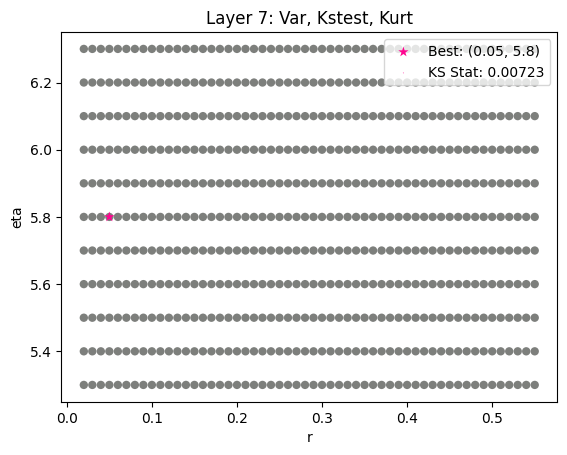

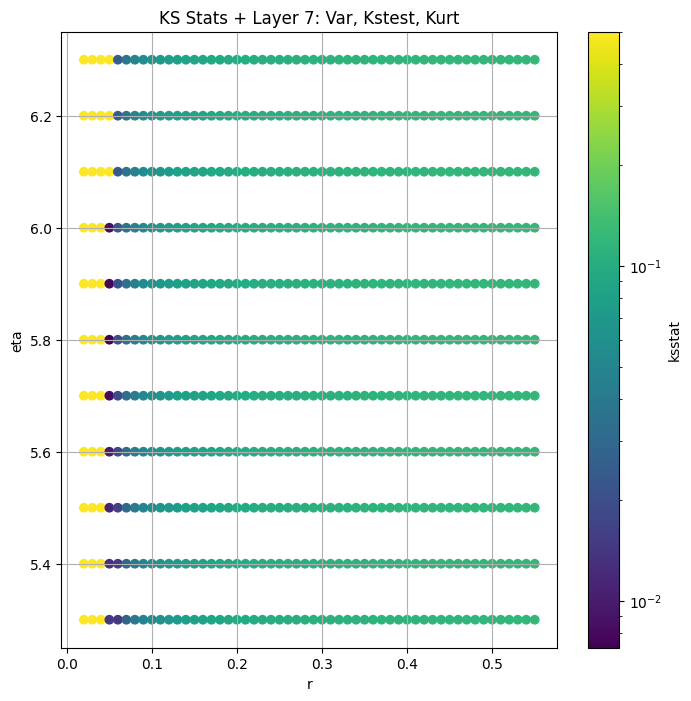

####
Layer  8
0
Variance: 0.0 - 1.7976931348623157e+308
Scale: 6.151167173949807e-308 - 100000.0


100%|██████████| 55966/55966 [03:01<00:00, 308.41it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 36864000.0


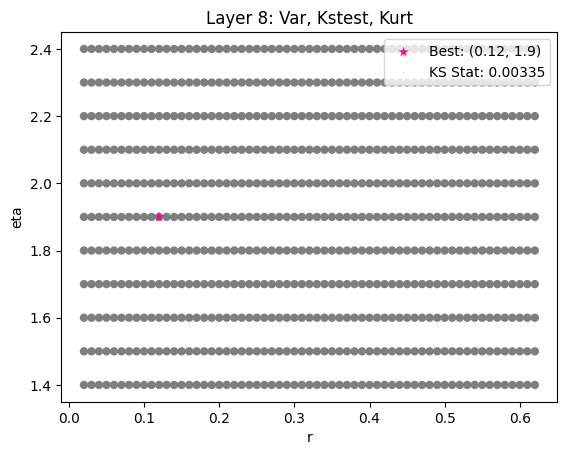

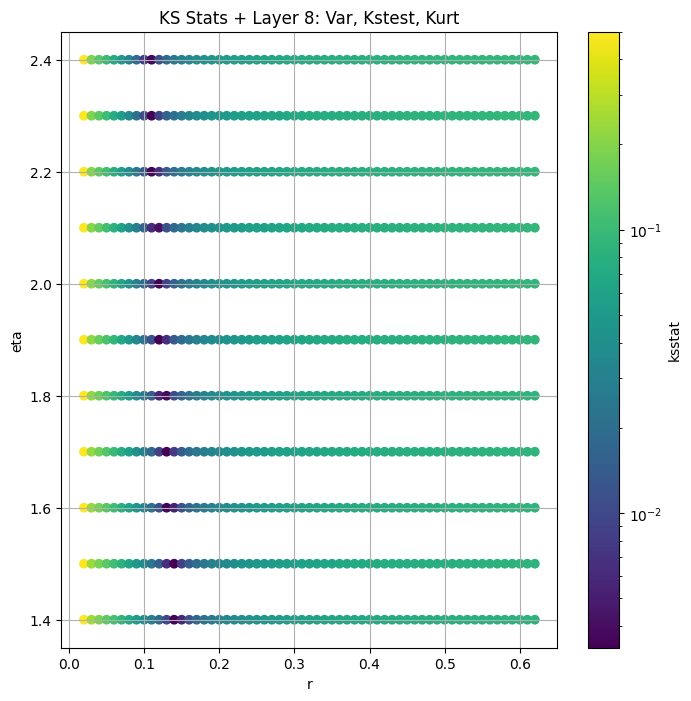

####
Layer  9
0
Variance: 0.0 - 1.7976931348623157e+308
Scale: 2.0864953314852653e-308 - 100000.0


100%|██████████| 55966/55966 [03:02<00:00, 307.41it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 147456000.0


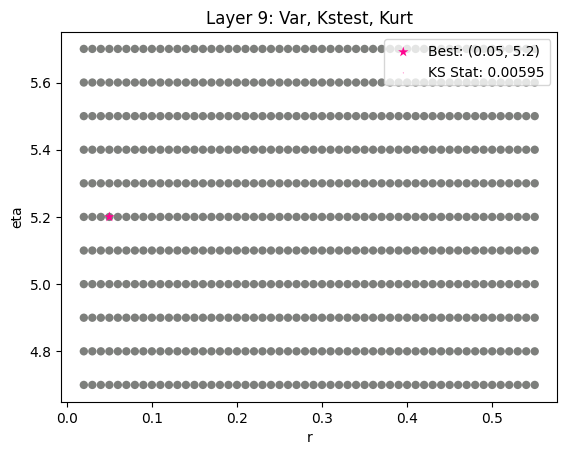

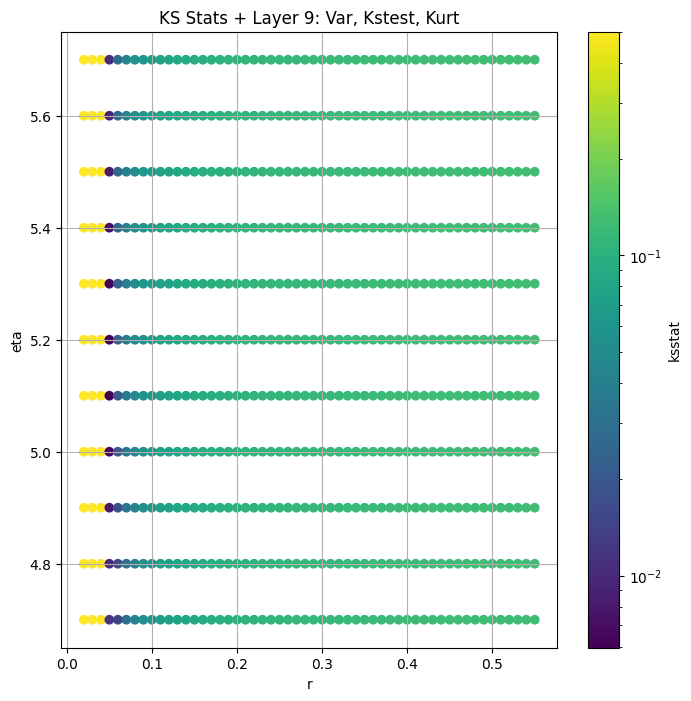

####
Layer  10
0
Variance: 0.0 - 1.7976931348623157e+308
Scale: 3.47837303935204e-309 - 100000.0


100%|██████████| 55966/55966 [03:00<00:00, 309.72it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 589824000.0


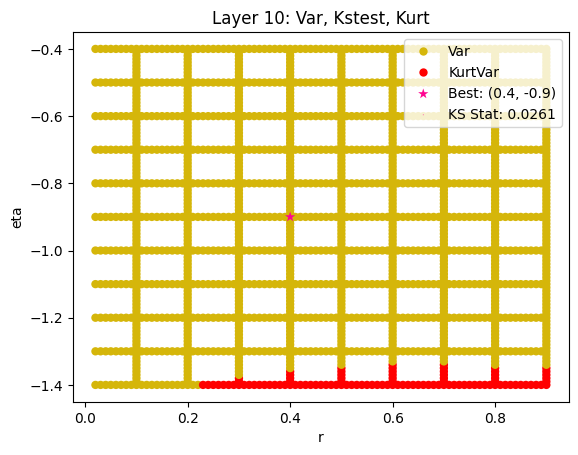

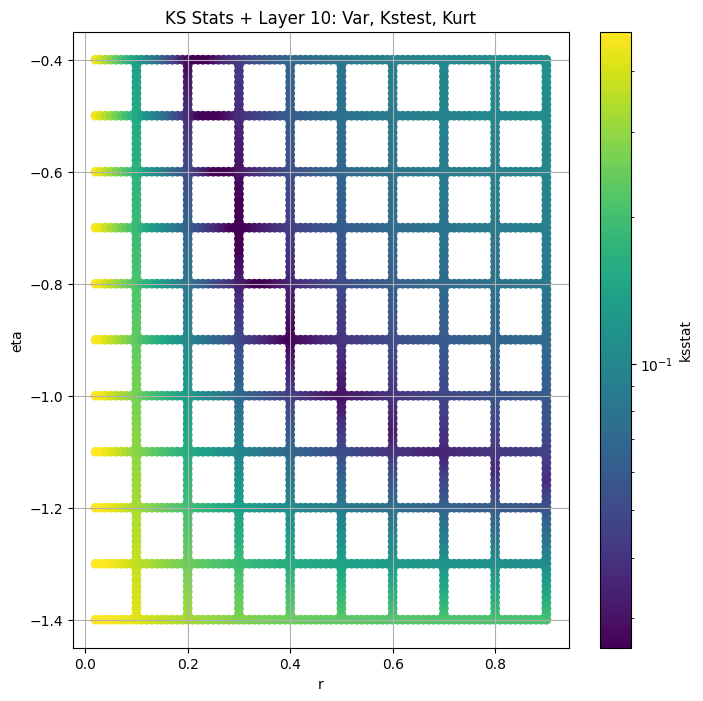

obs_var     var_lower      var_upper    obs_kurt  kurt_lower  \
layer                                                                       
2      188570.730000  99638.340000  330262.220000   536.03296  113.304540   
3       42568.312000  23773.760000   71607.330000   488.99530  135.974520   
4       10773.336000   5322.670000   20877.791000   785.24280  131.392270   
5        1800.434900    923.853000    3624.655000   858.03740  109.913740   
6         390.887500    183.288650     971.469850  1521.53970  104.035530   
7          98.479220     41.024357     351.604030  3306.70500   84.348870   
8          33.173733     15.926921     100.374084  2264.61400   78.321760   
9          11.252635      4.427865      43.877705  5137.09860   82.329865   
10          1.875914      0.615992      10.184826  9775.98100   78.684250   

       kurt_upper  total_samples  initial_r  initial_eta  initial_scale  \
layer                                                                     
2       760.94360         9000.0       0.06          4.0   3.234081e-29   
3       891.27313        36000.0       0.06          3.1   1.120499e-28   
4      1768.95340       144000.0       0.04          4.2   6.980172e-52   
5      2074.88330       576000.0       0.05          3.6   6.988790e-39   
6      3444.52950      2304000.0       0.05          4.5   7.553725e-41   
7      5672.12000      9216000.0       0.05          5.8   4.870738e-43   
8      4638.63770     36864000.0       0.12          1.9   3.242544e-12   
9      6105.37160    147456000.0       0.05          5.2   2.780466e-43   
10     7496.85840    589824000.0       0.40         -0.9   9.236032e-02   

       kstest_stat_initial  kstest_stat_cutoff_0.05  
layer                                                
2                 0.014795                 0.014297  
3                 0.014098                 0.007153  
4                 0.012705                 0.003578  
5                 0.009939                 0.001789  
6                 0.009085                 0.000895  
7                 0.007231                 0.000447  
8                 0.003350                 0.000224  
9                 0.005950                 0.000112  
10                0.026100                 0.000056

In [20]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    group_cdf_df_dict = dict()
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS):
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        group_cdf_df = all_cdfs_df.copy()
        #variance = np.var(group_data_map[group][1000:-1000])
        group_cdf_df['scale'] = np.clip(master_df.loc[group,'obs_var'] /3 / group_cdf_df['variance'], 0, 1e5)
        print(sum(group_cdf_df['scale'].isna()))
        print(f"Variance: {group_cdf_df['variance'].min()} - {group_cdf_df['variance'].max()}")
        print(f"Scale: {group_cdf_df['scale'].min()} - {group_cdf_df['scale'].max()}")
        ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdf_df['scale'])
        initial_scale = group_cdf_df.loc[(group_cdf_df["r"] ==  initial_param[0]) & (group_cdf_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
        master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
        master_df.loc[group, 'initial_scale'] = initial_scale
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        master_df.loc[group, 'kstest_stat_initial'] = min_stat
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        group_cdf_df['variance'] = group_cdf_df['variance'] * group_cdf_df['scale']
        group_cdf_df['kurtosis'] = group_cdf_df['kurtosis'] * group_cdf_df['scale']

        group_cdf_df = add_tests_to_df(cdfs_df = group_cdf_df, group = group, var_kurt_df = master_df, ksstats = ksstats)
        group_cdf_df_dict[group] = group_cdf_df
        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdf_df_dict[group], cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])}", 
                            target_var = None,
                            best_param = initial_param,
                            best_ksstat=min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=300)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdf_df_dict[group], var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdf_df_dict[group], kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(os.path.join(CWD, "CSVs", "master_df_combo.csv"))

master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
master_df

### Search over $\eta=0$

In [ ]:
master_df_eta0_path = Path(os.path.join(CWD, "CSVs", "master_df_eta0.csv"))

if RERUN or not master_df_eta0_path.exists():
    best_params_eta0 = []
    for i, group in enumerate(GROUPS):
        if master_df.loc[group, 'initial_eta'] != 0:
            sample = group_data_map[group]
            group_cdf = all_cdfs_df[all_cdfs_df['eta'] == 0]
            cdfs_dict = {i[0]:i[1] for i in group_cdf['(r,eta),cdf']}
            ksstats, best_param_eta0, kstest_stat_eta0 = gridsearch(sample, cdfs_dict, debug=True, scales=group_cdf_df['scale'])
            best_scale_eta0 = group_cdf_df.loc[(group_cdf_df["r"] ==  best_param_eta0[0]) & (group_cdf_df["eta"] ==  best_param_eta0[1])]["scale"].iloc[0]
            master_df.loc[group, 'best_r_eta0'] = best_param_eta0[0]
            master_df.loc[group, 'best_scale_eta0'] = best_scale_eta0
            master_df.loc[group, 'kstest_stat_eta0'] = kstest_stat_eta0
        else:
            master_df.loc[group, 'kstest_stat_eta0'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r_eta0'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_scale_eta0'] = master_df.loc[group, 'initial_scale']
    master_df.to_csv(os.path.join(CWD, "CSVs", "master_df_eta0.csv"))

master_df = pd.read_csv(master_df_eta0_path, index_col=GROUP)
master_df

obs_var     var_lower      var_upper    obs_kurt  kurt_lower  \
layer                                                                       
2      188570.730000  99638.340000  330262.220000   536.03296  113.304540   
3       42568.312000  23773.760000   71607.330000   488.99530  135.974520   
4       10773.336000   5322.670000   20877.791000   785.24280  131.392270   
5        1800.434900    923.853000    3624.655000   858.03740  109.913740   
6         390.887500    183.288650     971.469850  1521.53970  104.035530   
7          98.479220     41.024357     351.604030  3306.70500   84.348870   
8          33.173733     15.926921     100.374084  2264.61400   78.321760   
9          11.252635      4.427865      43.877705  5137.09860   82.329865   
10          1.875914      0.615992      10.184826  9775.98100   78.684250   

       kurt_upper  total_samples  initial_r  initial_eta  initial_scale  \
layer                                                                     
2       760.94360         9000.0       0.04          3.4   1.183211e-48   
3       891.27313        36000.0       0.04          2.8   5.184677e-48   
4      1768.95340       144000.0       0.04          2.2   3.805437e-47   
5      2074.88330       576000.0       0.04          2.4   1.966347e-48   
6      3444.52950      2304000.0       0.04          2.8   4.760878e-50   
7      5672.12000      9216000.0       0.04          3.3   9.891023e-52   
8      4638.63770     36864000.0       0.04          3.7   5.340944e-53   
9      6105.37160    147456000.0       0.04          3.0   4.901033e-52   
10     7496.85840    589824000.0       0.04          2.6   6.678594e-52   

       kstest_stat_initial  kstest_stat_cutoff_0.05  best_r_eta0  \
layer                                                              
2                 0.024065                 0.014297         6.00   
3                 0.025912                 0.007153         6.00   
4                 0.028665                 0.003578         5.90   
5                 0.025973                 0.001789         5.80   
6                 0.027879                 0.000895         5.80   
7                 0.028445                 0.000447         5.80   
8                 0.021401                 0.000224         5.80   
9                 0.024747                 0.000112         5.80   
10                0.029243                 0.000056         0.03   

       best_scale_eta0  kstest_stat_eta0  
layer                                     
2         3.196781e+00          0.127747  
3         3.196781e+00          0.246668  
4         3.194657e+00          0.336533  
5         3.192366e+00          0.397519  
6         3.192366e+00          0.435426  
7         3.192366e+00          0.458974  
8         3.192366e+00          0.469514  
9         3.192366e+00          0.479910  
10        5.510364e-61          0.481630

## Optimization

In [ ]:
def simple_add_cdfs(r_range, eta_range, dir, folder_name = '', n_samples = 500, tail_bound = 0.01, tail_percent = 0.1, enforce_assert=True, return_assert = False, debug=False):

    if folder_name == '':
        folder_name = f'r{round_to_sigfigs(min(r_range))}to{round_to_sigfigs(max(r_range))}_eta{round_to_sigfigs(min(eta_range))}to{round_to_sigfigs(max(eta_range))}'

    FOLDER_PATH = os.path.join(dir, folder_name)

    if os.path.isdir(FOLDER_PATH):
        cdfs_completed = combine_pickles(FOLDER_PATH)
        if debug:
            print("CDFs completed:", len(cdfs_completed))
    else:
        Path(os.path.join(os.getcwd(), FOLDER_PATH)).mkdir()
        cdfs_completed = dict()

    n = len(r_range)*len(eta_range)
    finished = len(cdfs_completed)
    cnt = len(cdfs_completed)
    for r in r_range:
        r_cdf = dict()
        r = round_to_sigfigs(r)
        for eta in eta_range:
            eta = round_to_sigfigs(eta)
            if ((r, eta) in cdfs_completed) and cdfs_completed[(r, eta)]:
                continue
            cnt += 1
            if debug:
                print(f'{(r, eta)}, {cnt} of {n + finished}')
            if cnt % 50 == 0:
                print(f'{(r, eta)}, {cnt} of {n + finished}')

            computed_cdf = compute_prior_cdf(r = r, eta = eta, method = 'gamma_cdf', n_samples = n_samples, tail_percent = tail_percent, tail_bound = tail_bound, 
                                             enforce_assert=enforce_assert, return_assert=return_assert, debug=debug)
            r_cdf[(r, eta)] = computed_cdf
        if r_cdf:
            sorted_r_cdf = [i[1] for i in sorted(r_cdf)]
            min_eta, max_eta = round_to_sigfigs(min(sorted_r_cdf), 6), round_to_sigfigs(max(sorted_r_cdf), 6)
            pkl_path = os.path.join(FOLDER_PATH, f'r{r}_eta{min_eta}to{max_eta}.pickle')
            pd.to_pickle(r_cdf, pkl_path)
        else:
            if debug:
                print(f"Skipped {r} entirely")

    if debug:
        print(f'You can find the CDFs here: {os.path.join(os.getcwd(), FOLDER_PATH)}')

In [ ]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))


SKIP_OPTIMIZE_STEP = False
NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS)))
NUM_SAMPLES_OPTIMIZE = 2000

if RERUN or not master_df_optimized_path.exists():
    rEtaKsstats_dict = dict()

    if SKIP_OPTIMIZE_STEP:
        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
    else:
        for group in GROUPS: 
            print(f"{GROUP.capitalize()} {group}")
            sample = group_data_map[group]
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            r_granularity = 10
            eta_granularity = 10
            for i in range(0, -5, -1):
                if tuple([round_to_sigfigs(initial_r + 10.**i, 8), initial_eta]) in all_cdfs:
                    r_granularity = 10.**i
                if tuple([initial_r, round_to_sigfigs(initial_eta + 10.**i, 8)]) in all_cdfs:
                    
                    eta_granularity = 10.**i

            for d in range(1, NUM_ITERS[group] + 1):
                if d == 1:
                    initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
                else:
                    initial_r, initial_eta = master_df.loc[group, f'iter{d - 1}_r'], master_df.loc[group, f'iter{d - 1}_eta']
                r_granularity = r_granularity * 10.0**(-d+1) 
                eta_granularity = eta_granularity * 10.0**(-d+1) 

                r_range = [round_to_sigfigs(x) for x in np.arange(initial_r - r_granularity, initial_r + r_granularity, r_granularity/10)]
                eta_range = [round_to_sigfigs(x) for x in np.arange(initial_eta - eta_granularity, initial_eta + eta_granularity, eta_granularity/10)]
                simple_add_cdfs(r_range, eta_range, dir = os.path.join(CWD, "groupCDFs"), folder_name=f'{GROUP}{group}', n_samples = NUM_SAMPLES_OPTIMIZE, debug=False, tail_bound=1e-5)
                cdfs_dict = combine_pickles(os.path.join(CWD, "groupCDFs", f'{GROUP}{group}'))
                

                temp_df = create_kurt_var_ksstat_df(cdfs_dict)
                temp_df['scale'] = np.clip(master_df.loc[group,'obs_var'] / temp_df['variance'], 0, 1e5)
                temp_df['variance'] = temp_df['variance'] * temp_df['scale']
                temp_df['kurtosis'] = temp_df['kurtosis'] * temp_df['scale']
                ksstats, best_param, kstest_stat = gridsearch(sample, cdfs_dict, debug=True, scales=temp_df['scale'])
                temp_df = add_tests_to_df(cdfs_df=temp_df, group=group, var_kurt_df=master_df, ksstats=ksstats)
                
                group_cdf_df_dict[group] = pd.concat([group_cdf_df_dict[group], temp_df])
                master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta'] = best_param[0], best_param[1]
                best_scale = temp_df.loc[(temp_df["r"] ==  best_param[0])&(temp_df["eta"] ==  best_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'best_scale'] = best_scale
                master_df.loc[group, 'kstest_stat_best'] = kstest_stat
                master_df.loc[group, f'iter{d}_r'], master_df.loc[group, f'iter{d}_eta'] = best_param[0], best_param[1]
                master_df.loc[group, f'kstest_stat_iter{d}'] = kstest_stat
                
                print(f"Iter {d} {GROUP} {group} best parameters: {best_param, master_df.loc[group, f'kstest_stat_iter{d}']}")

            temp_df = group_cdf_df_dict[group].sort_values(['r', 'eta'])
            rEtaKsstats_dict[group] = [temp_df['r'], temp_df['eta'], temp_df['ksstat']]

            eps = 0.1
            filtered_df = temp_df[(temp_df['r'] > master_df.loc[group, 'initial_r'] - eps) & 
                            (temp_df['r'] < master_df.loc[group, 'initial_r'] + eps) &
                            (temp_df['eta'] > master_df.loc[group, 'initial_eta'] - eps) &
                            (temp_df['eta'] < master_df.loc[group, 'initial_eta'] + eps)]
            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(filtered_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=kstest_stat)
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=300)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    pd.to_pickle(rEtaKsstats_dict, os.path.join(CWD, "cache", 'rEtaKsstats_dict.pickle'))

master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
master_df

obs_var     var_lower      var_upper    obs_kurt  kurt_lower  \
layer                                                                       
2      188570.730000  99638.340000  330262.220000   536.03296  113.304540   
3       42568.312000  23773.760000   71607.330000   488.99530  135.974520   
4       10773.336000   5322.670000   20877.791000   785.24280  131.392270   
5        1800.434900    923.853000    3624.655000   858.03740  109.913740   
6         390.887500    183.288650     971.469850  1521.53970  104.035530   
7          98.479220     41.024357     351.604030  3306.70500   84.348870   
8          33.173733     15.926921     100.374084  2264.61400   78.321760   
9          11.252635      4.427865      43.877705  5137.09860   82.329865   
10          1.875914      0.615992      10.184826  9775.98100   78.684250   

       kurt_upper  total_samples  initial_r  initial_eta  initial_scale  ...  \
layer                                                                    ...   
2       760.94360         9000.0       0.04          3.4   1.183211e-48  ...   
3       891.27313        36000.0       0.04          2.8   5.184677e-48  ...   
4      1768.95340       144000.0       0.04          2.2   3.805437e-47  ...   
5      2074.88330       576000.0       0.04          2.4   1.966347e-48  ...   
6      3444.52950      2304000.0       0.04          2.8   4.760878e-50  ...   
7      5672.12000      9216000.0       0.04          3.3   9.891023e-52  ...   
8      4638.63770     36864000.0       0.04          3.7   5.340944e-53  ...   
9      6105.37160    147456000.0       0.04          3.0   4.901033e-52  ...   
10     7496.85840    589824000.0       0.04          2.6   6.678594e-52  ...   

       best_scale_eta0  kstest_stat_eta0  best_r  best_eta    best_scale  \
layer                                                                      
2         3.196781e+00          0.127747   0.040      3.38  1.299022e-48   
3         3.196781e+00          0.246668   0.039      2.89  7.798996e-50   
4         3.194657e+00          0.336533   0.039      2.24  7.887663e-49   
5         3.192366e+00          0.397519   0.040      2.40  1.966347e-48   
6         3.192366e+00          0.435426   0.039      2.90  6.793340e-52   
7         3.192366e+00          0.458974   0.039      3.37  1.607840e-53   
8         3.192366e+00          0.469514   0.040      3.70  5.340944e-53   
9         3.192366e+00          0.479910   0.040      3.02  4.432256e-52   
10        5.510364e-61          0.481630   0.039      2.69  1.011143e-53   

       kstest_stat_best  iter1_r  iter1_eta  kstest_stat_iter1  n_pval_0.05  
layer                                                                        
2              0.023756    0.040       3.38           0.023756         3375  
3              0.025071    0.039       2.89           0.025071         2845  
4              0.027053    0.039       2.24           0.027053         2530  
5              0.025973    0.040       2.40           0.025973         2845  
6              0.027513    0.039       2.90           0.027513         2530  
7              0.027626    0.039       3.37           0.027626         2530  
8              0.021401    0.040       3.70           0.021401         4050  
9              0.024379    0.040       3.02           0.024379         3199  
10             0.028674    0.039       2.69           0.028674         2250  

[9 rows x 23 columns]

## Comparing Empirical and Computed CDF/PDF

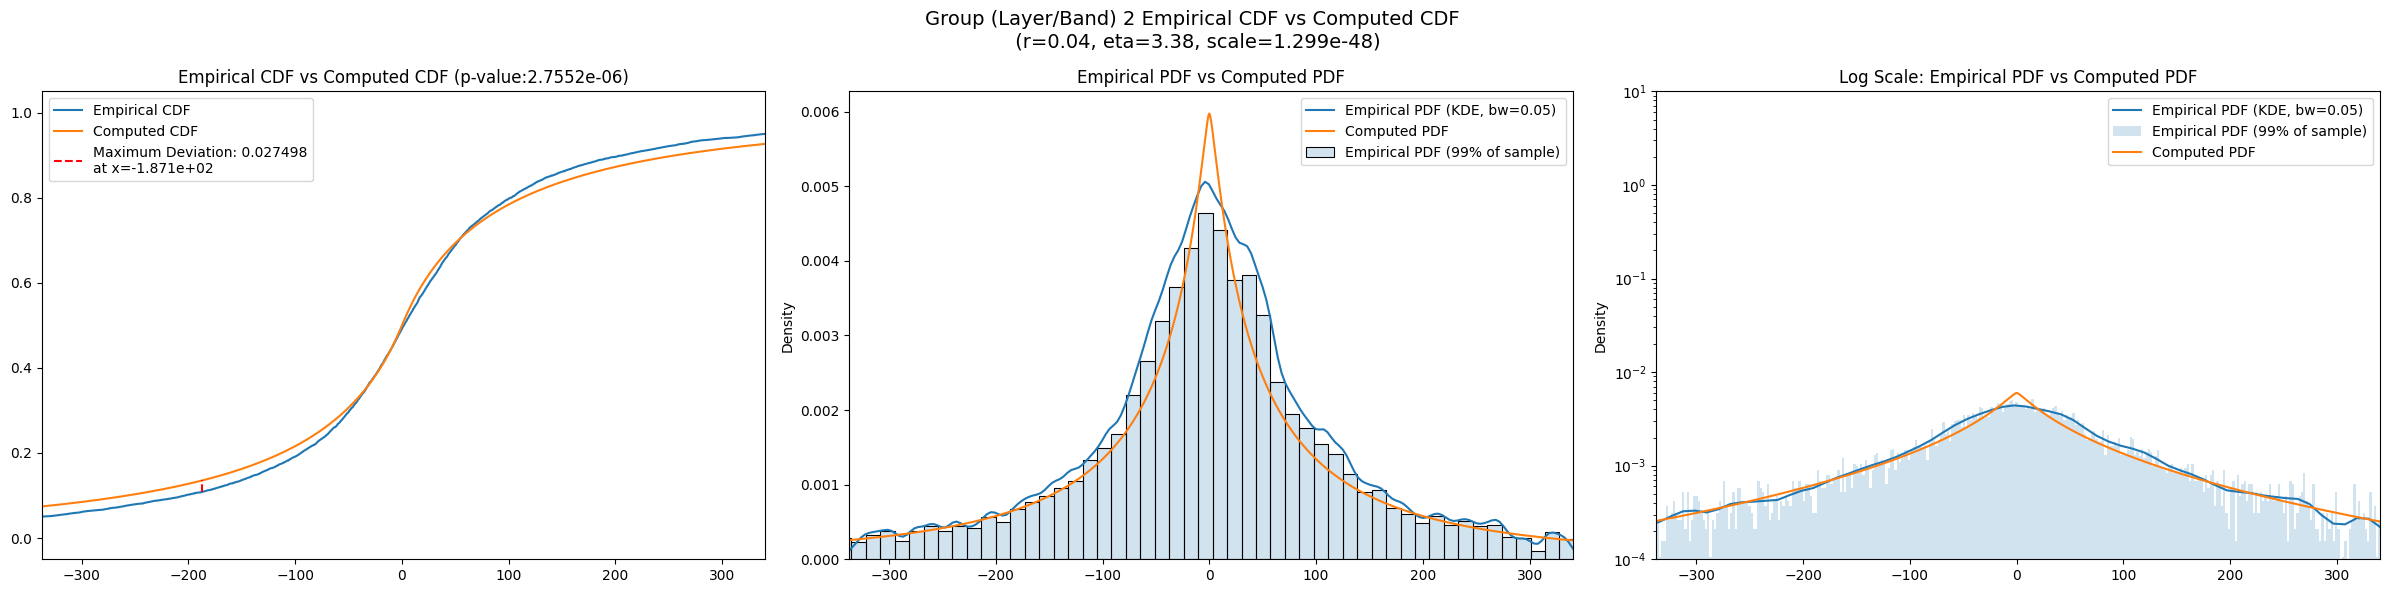

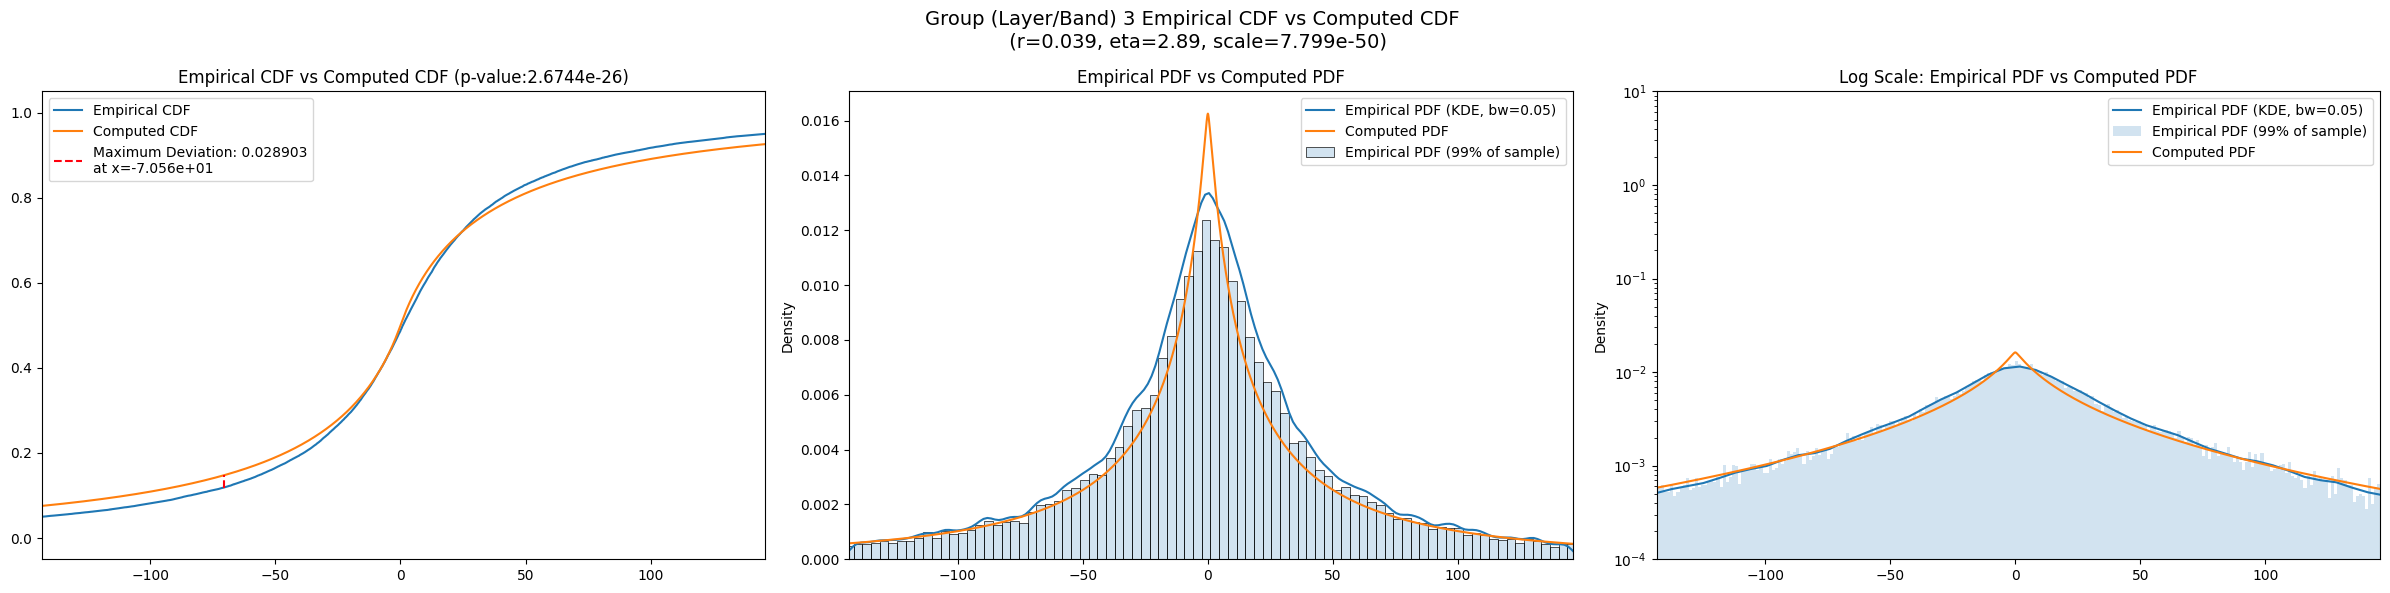

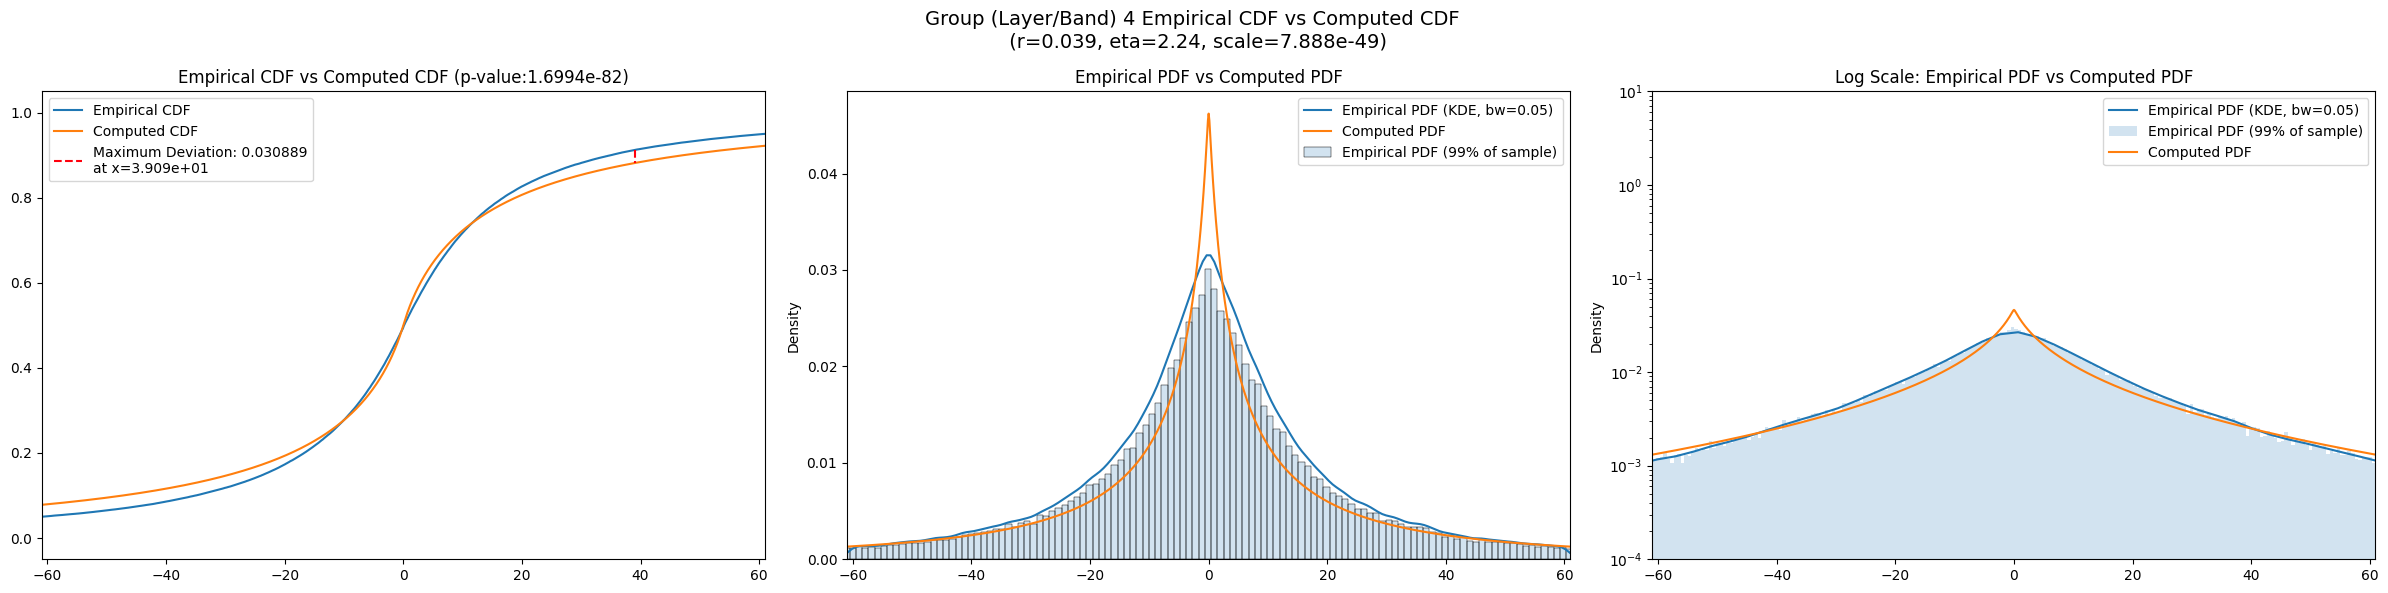

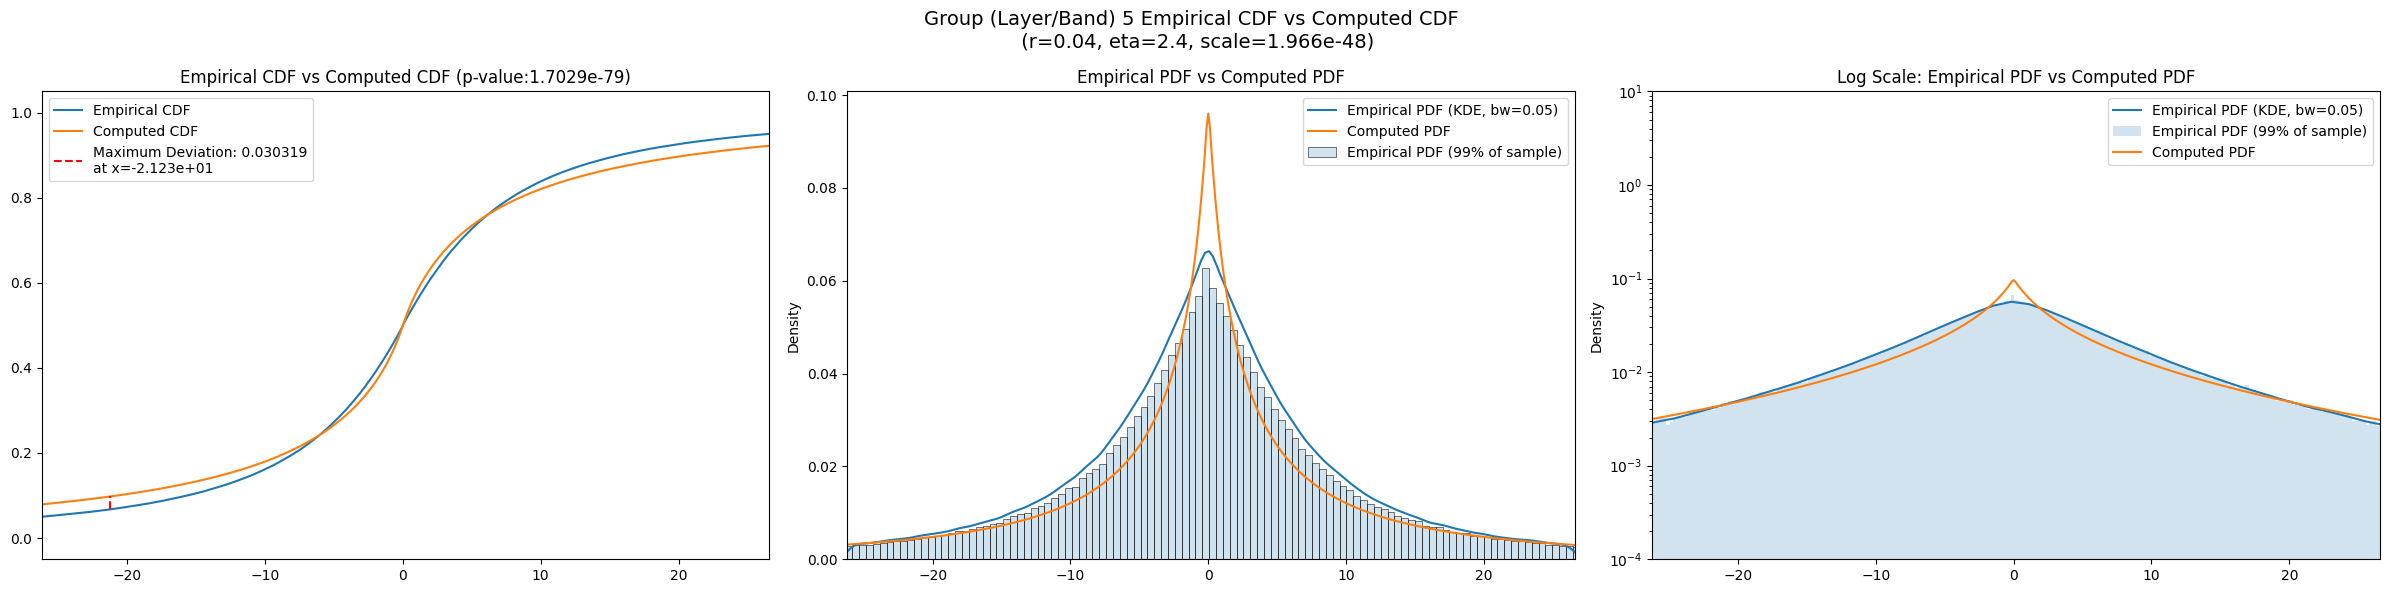

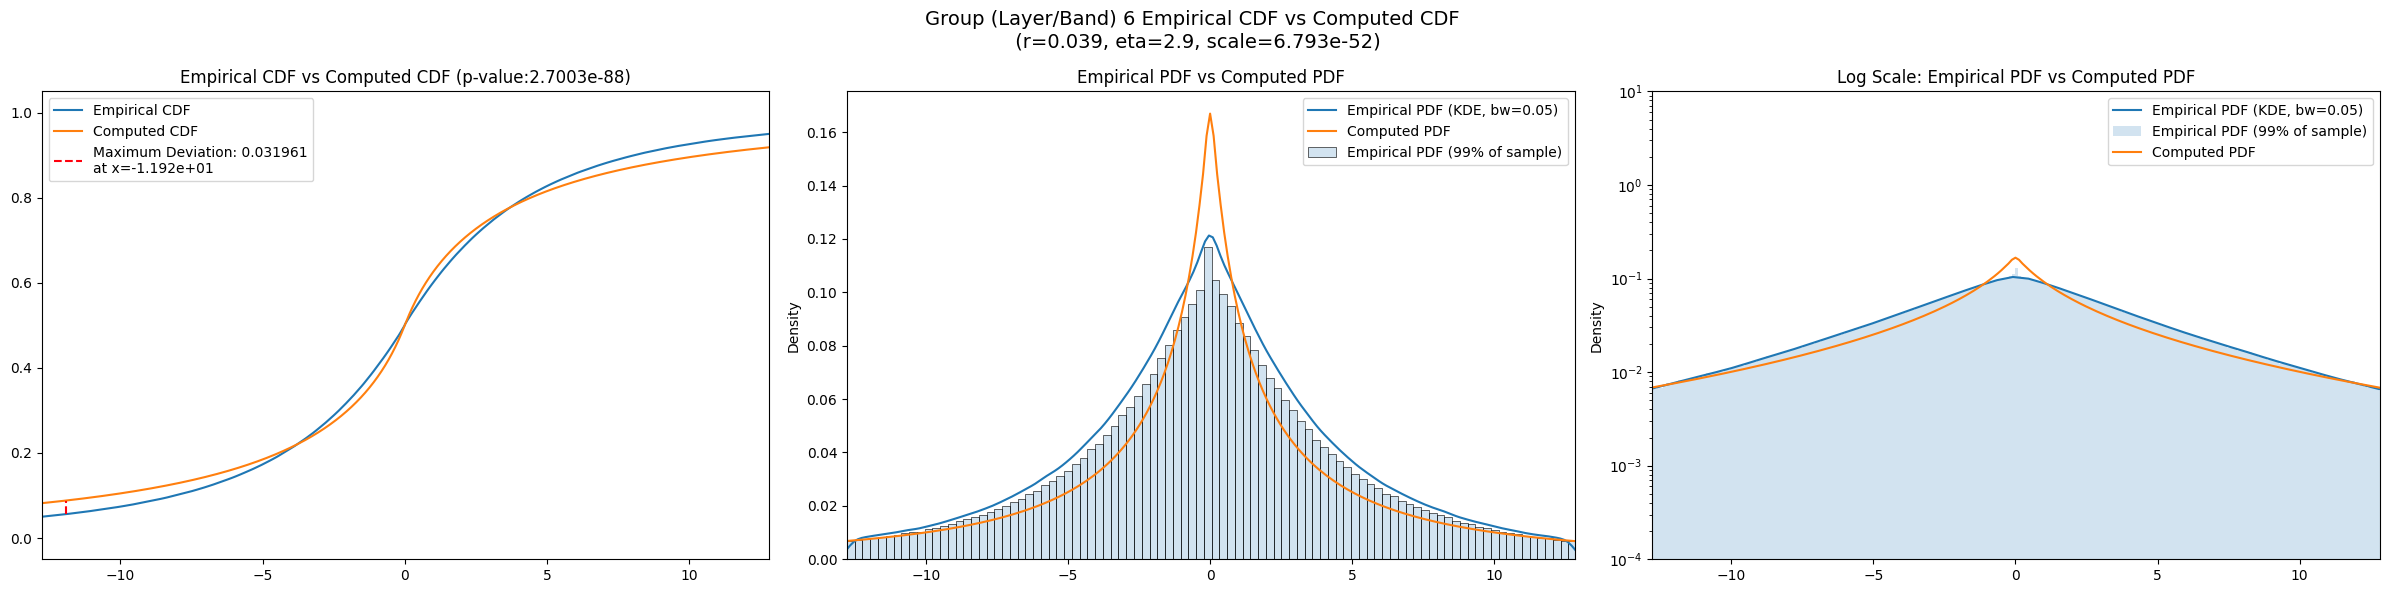

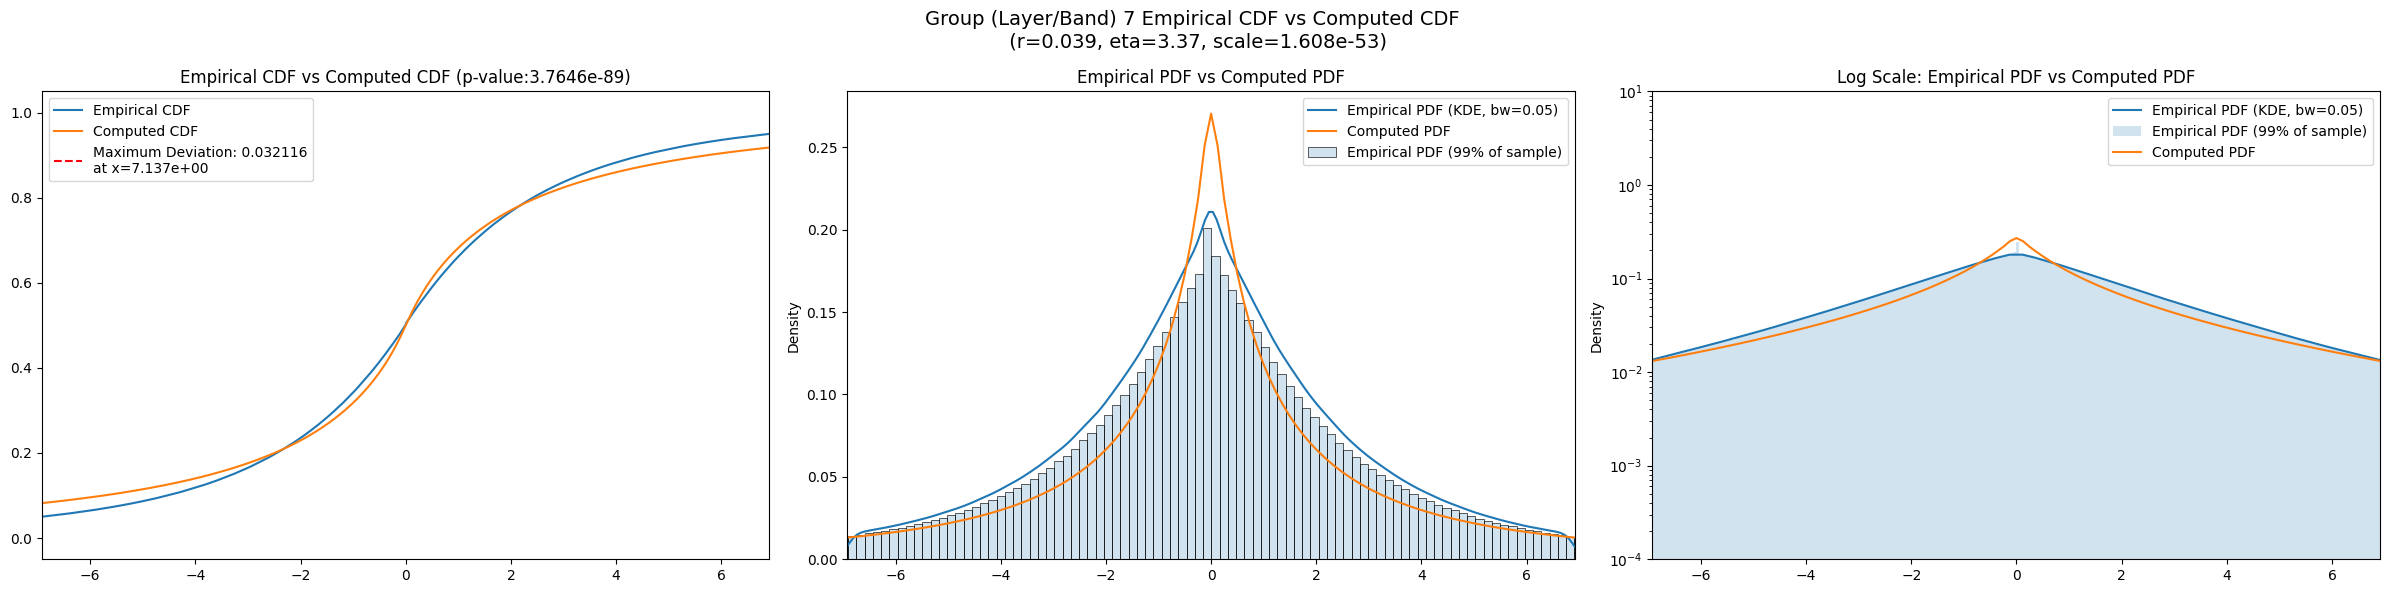

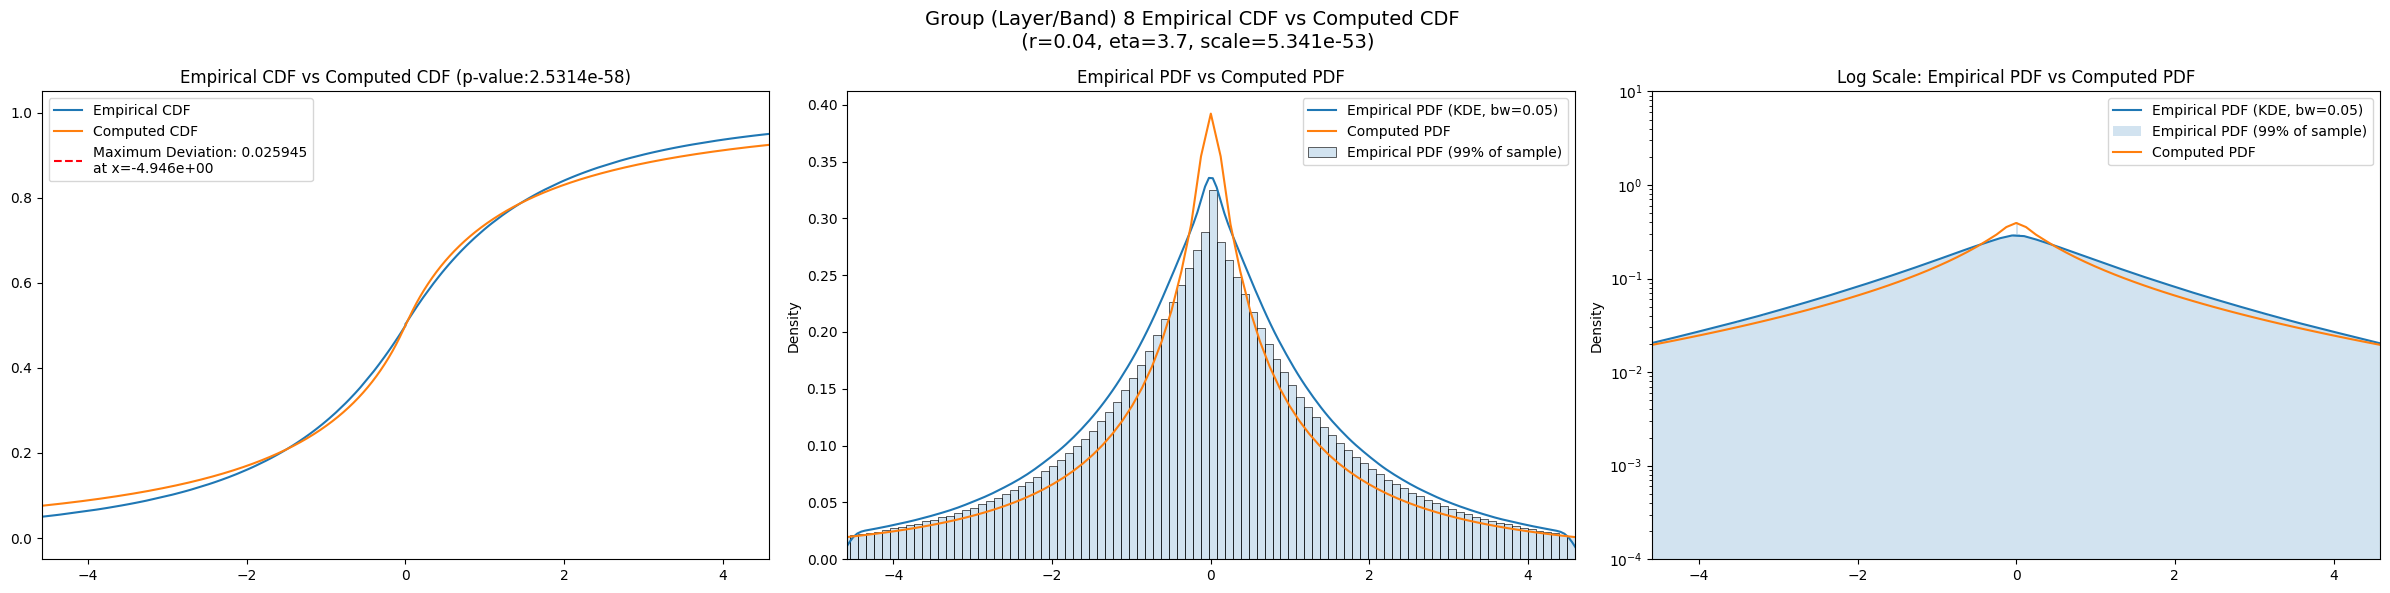

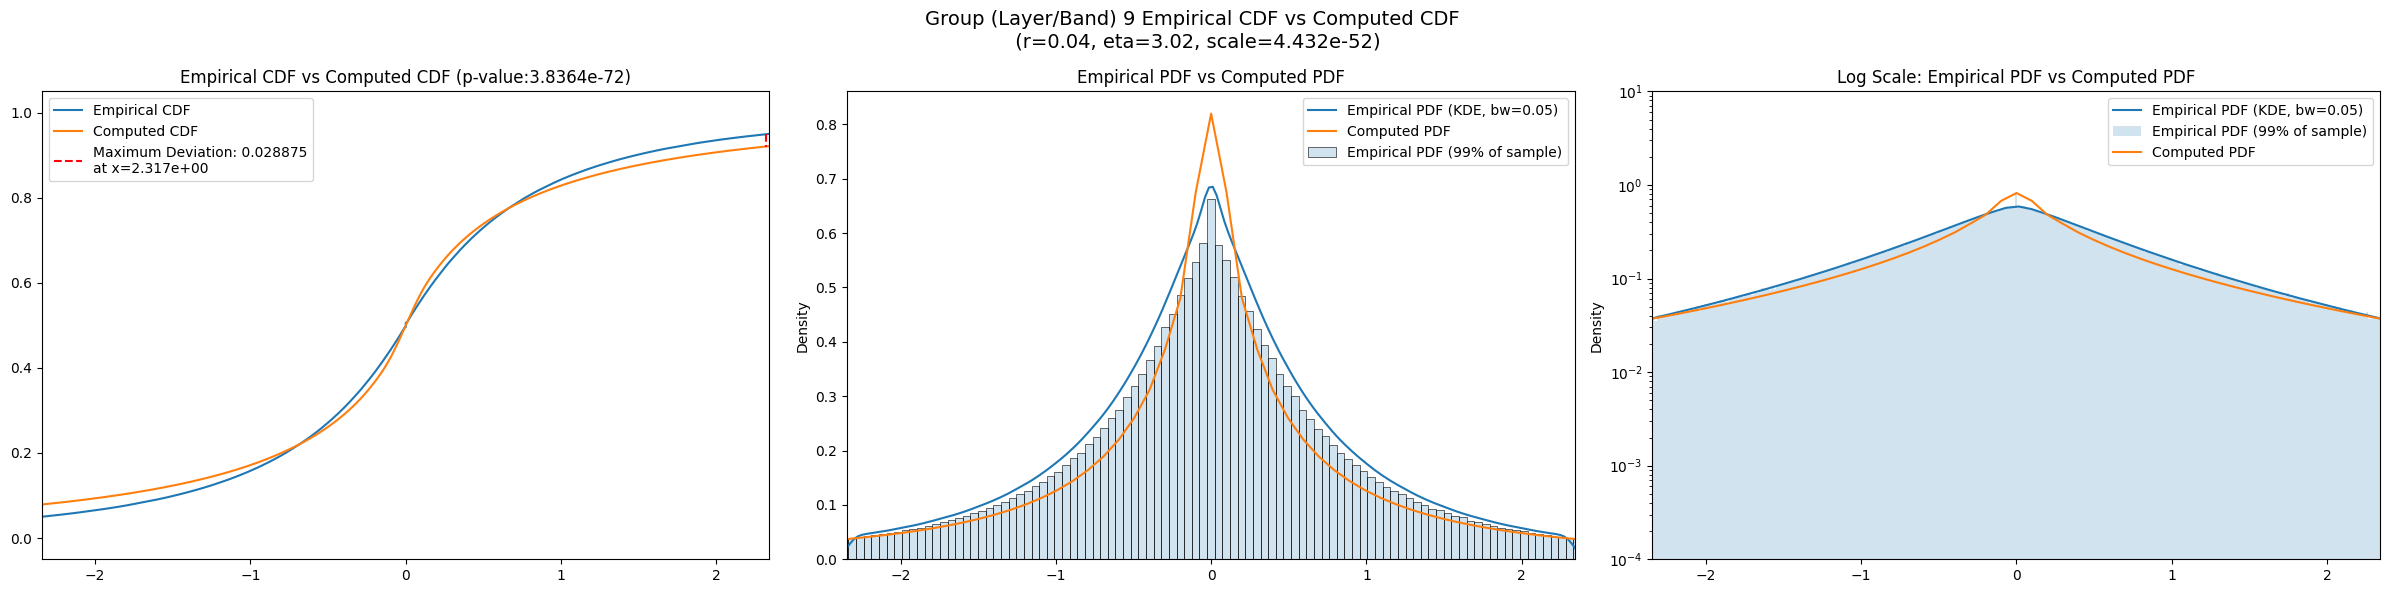

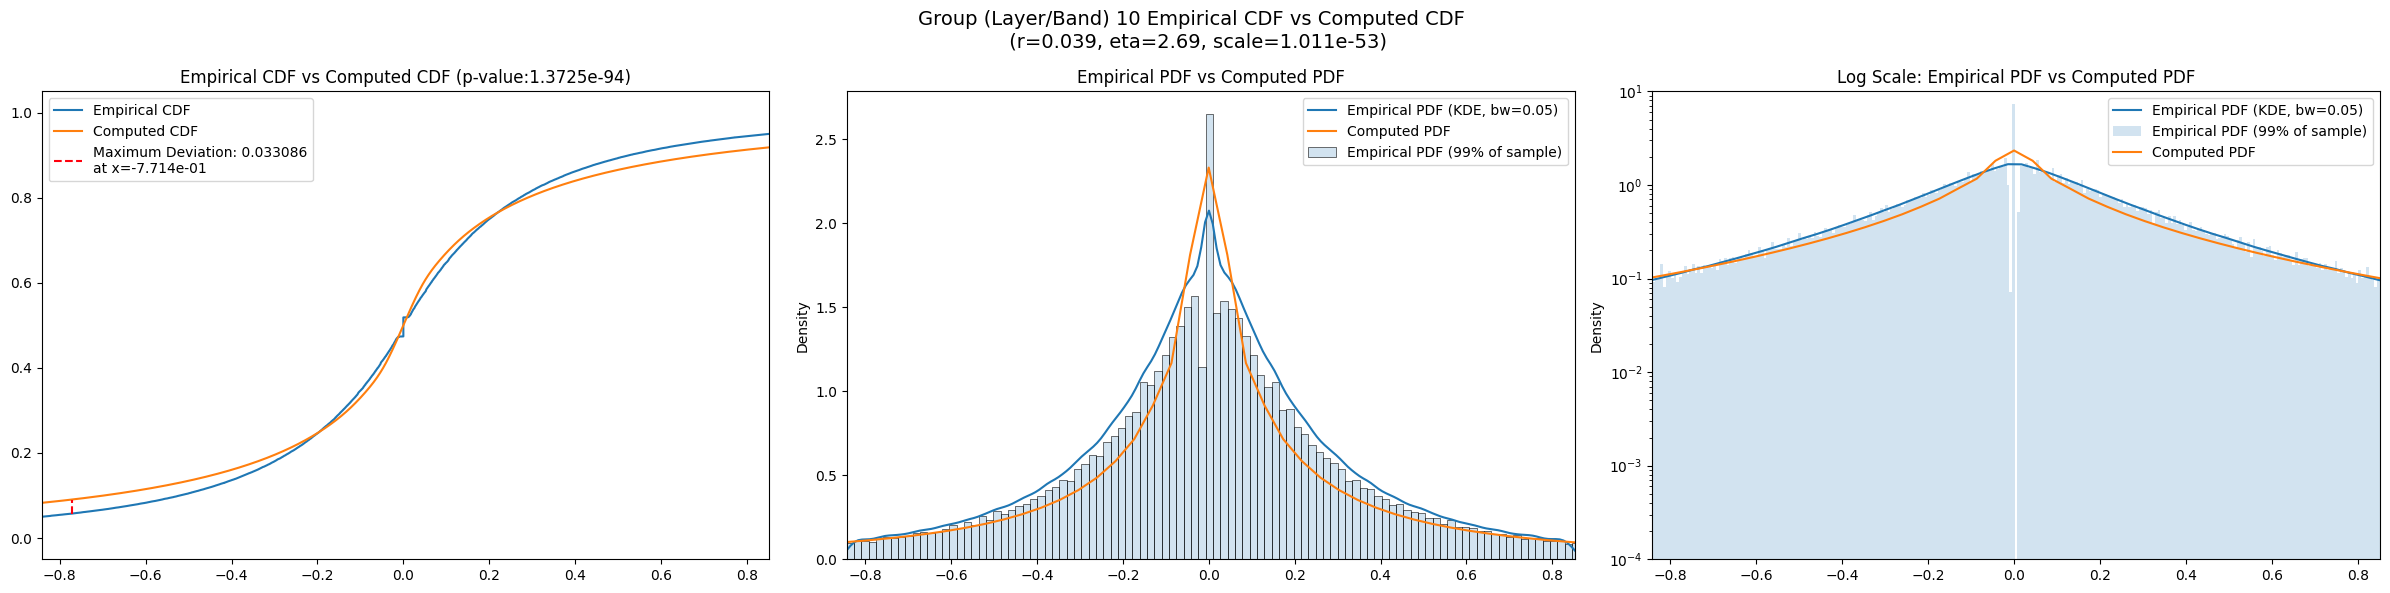

In [ ]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group,
                    bw=0.05,
                    bw_log=0.05,
                    percent_excluded=1, 
                    plot_hist=True)
    # fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 600)

## Comparing with Gaussian and Laplace Priors

In [ ]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample / np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [ ]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var     var_lower      var_upper    obs_kurt  kurt_lower  \
layer                                                                       
2      188570.730000  99638.340000  330262.220000   536.03296  113.304540   
3       42568.312000  23773.760000   71607.330000   488.99530  135.974520   
4       10773.336000   5322.670000   20877.791000   785.24280  131.392270   
5        1800.434900    923.853000    3624.655000   858.03740  109.913740   
6         390.887500    183.288650     971.469850  1521.53970  104.035530   
7          98.479220     41.024357     351.604030  3306.70500   84.348870   
8          33.173733     15.926921     100.374084  2264.61400   78.321760   
9          11.252635      4.427865      43.877705  5137.09860   82.329865   
10          1.875914      0.615992      10.184826  9775.98100   78.684250   

       kurt_upper  total_samples  initial_r  initial_eta  initial_scale  ...  \
layer                                                                    ...   
2       760.94360         9000.0       0.04          3.4   1.183211e-48  ...   
3       891.27313        36000.0       0.04          2.8   5.184677e-48  ...   
4      1768.95340       144000.0       0.04          2.2   3.805437e-47  ...   
5      2074.88330       576000.0       0.04          2.4   1.966347e-48  ...   
6      3444.52950      2304000.0       0.04          2.8   4.760878e-50  ...   
7      5672.12000      9216000.0       0.04          3.3   9.891023e-52  ...   
8      4638.63770     36864000.0       0.04          3.7   5.340944e-53  ...   
9      6105.37160    147456000.0       0.04          3.0   4.901033e-52  ...   
10     7496.85840    589824000.0       0.04          2.6   6.678594e-52  ...   

       param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
layer                                                               
2          131.899000              0.055415          1.834910e-24   
3           53.584400              0.057770         7.115700e-105   
4           23.148600              0.054251          0.000000e+00   
5           10.882500              0.048652          0.000000e+00   
6            5.731200              0.042154          0.000000e+00   
7            3.212460              0.039117          0.000000e+00   
8            2.081460              0.041292          0.000000e+00   
9            1.034170              0.043593          0.000000e+00   
10           0.361633              0.046655          0.000000e+00   

       param_laplace  kstest_stat_laplace  kstest_pval_laplace    param_t  \
layer                                                                       
2         116.308000             0.029473         3.166700e-07  93.613400   
3          47.514500             0.031681         7.939590e-32  37.265100   
4          20.677300             0.028975        1.831090e-105  16.103000   
5           9.712140             0.023931        5.558780e-287   7.601830   
6           5.101670             0.017177         0.000000e+00   4.012160   
7           2.846970             0.013100         0.000000e+00   2.265980   
8           1.837490             0.014487         0.000000e+00   1.467140   
9           0.914581             0.017191         0.000000e+00   0.725643   
10          0.298702             0.026100         0.000000e+00   0.237466   

       kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
layer                                                      
2           0.026207   8.390310e-06          7.618473e-05  
3           0.030362   2.889150e-29          4.332112e-20  
4           0.024964   2.153860e-78          5.482051e-92  
5           0.018934  8.485670e-180          0.000000e+00  
6           0.013458   0.000000e+00          0.000000e+00  
7           0.012420   0.000000e+00          0.000000e+00  
8           0.014351   0.000000e+00          0.000000e+00  
9           0.015611   0.000000e+00          0.000000e+00  
10          0.026100   0.000000e+00          0.000000e+00  

[9 rows x 33 co

## Results

In [ ]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [ ]:
master_df.filter(regex='kstest_stat.*')

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_eta0  \
layer                                                                   
2                 0.024065                 0.014297          0.127747   
3                 0.025912                 0.007153          0.246668   
4                 0.028665                 0.003578          0.336533   
5                 0.025973                 0.001789          0.397519   
6                 0.027879                 0.000895          0.435426   
7                 0.028445                 0.000447          0.458974   
8                 0.021401                 0.000224          0.469514   
9                 0.024747                 0.000112          0.479910   
10                0.029243                 0.000056          0.481630   

       kstest_stat_best  kstest_stat_iter1  kstest_stat_gaussian  \
layer                                                              
2              0.023756           0.023756              0.055415   
3              0.025071           0.025071              0.057770   
4              0.027053           0.027053              0.054251   
5              0.025973           0.025973              0.048652   
6              0.027513           0.027513              0.042154   
7              0.027626           0.027626              0.039117   
8              0.021401           0.021401              0.041292   
9              0.024379           0.024379              0.043593   
10             0.028674           0.028674              0.046655   

       kstest_stat_laplace  kstest_stat_t  
layer                                      
2                 0.029473       0.026207  
3                 0.031681       0.030362  
4                 0.028975       0.024964  
5                 0.023931       0.018934  
6                 0.017177       0.013458  
7                 0.013100       0.012420  
8                 0.014487       0.014351  
9                 0.017191       0.015611  
10                0.026100       0.026100

In [ ]:
master_df.filter(regex='param.*')

param_gaussian  param_laplace    param_t
layer                                          
2          131.899000     116.308000  93.613400
3           53.584400      47.514500  37.265100
4           23.148600      20.677300  16.103000
5           10.882500       9.712140   7.601830
6            5.731200       5.101670   4.012160
7            3.212460       2.846970   2.265980
8            2.081460       1.837490   1.467140
9            1.034170       0.914581   0.725643
10           0.361633       0.298702   0.237466

In [ ]:
group_data_map[7]

array([-860.3125 , -512.625  , -435.15106, ...,  455.25   ,  545.6875 ,
       1221.5625 ], dtype=float32)

In [ ]:
np.var(group_data_map[7])

98.47922

In [ ]:
np.var(group_data_map[7][1000:-1000])

15.958571

In [ ]:
np.var(group_data_map[7][1000:-1000]) / np.var(group_data_map[7])

0.16205014

In [ ]:
group_total_samples

{2: 9000,
 3: 36000,
 4: 144000,
 5: 576000,
 6: 2304000,
 7: 9216000,
 8: 36864000,
 9: 147456000,
 10: 589824000}

In [ ]:
from scipy import stats
stats.laplace(scale=master_df.loc[7, 'param_laplace']).var()

np.float64(16.210476361799998)

In [ ]:
eng.quit()
remove_directory(os.path.join(CWD, "groupCDFs"))

NameError: name 'eng' is not defined